## Модуль 1: Предобработка и разведочный анализ данных

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Настройка отображения
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

#### 1.1 Загрузка и первичный осмотр данных

In [3]:
# Загрузка данных
df = pd.read_csv('data.csv')

# Основная информация о данных
print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о типах данных:")
print(df.info())
print("\nСтатистическое описание числовых признаков:")
print(df.describe())

# Описание признаков
features_description = {
    'customerID': 'Идентификатор клиента (номинативный) - исключить из анализа',
    'gender': 'Пол (бинарный: Male/Female)',
    'SeniorCitizen': 'Пожилой гражданин (бинарный: 0/1)',
    'Partner': 'Наличие партнёра (бинарный: Yes/No)',
    'Dependents': 'Наличие иждивенцев (бинарный: Yes/No)',
    'tenure': 'Срок пользования услугами (количественный, в месяцах)',
    'PhoneService': 'Телефонная услуга (бинарный: Yes/No)',
    'MultipleLines': 'Несколько линий (категориальный: Yes/No/No phone service)',
    'InternetService': 'Тип интернет-услуги (категориальный: DSL/Fiber optic/No)',
    'OnlineSecurity': 'Онлайн-безопасность (категориальный: Yes/No/No internet service)',
    'OnlineBackup': 'Онлайн-резервное копирование (категориальный: Yes/No/No internet service)',
    'DeviceProtection': 'Защита устройства (категориальный: Yes/No/No internet service)',
    'TechSupport': 'Техническая поддержка (категориальный: Yes/No/No internet service)',
    'StreamingTV': 'Стриминг ТВ (категориальный: Yes/No/No internet service)',
    'StreamingMovies': 'Стриминг фильмов (категориальный: Yes/No/No internet service)',
    'Contract': 'Тип контракта (порядковый: Month-to-month/One year/Two year)',
    'PaperlessBilling': 'Безбумажный биллинг (бинарный: Yes/No)',
    'PaymentMethod': 'Способ оплаты (категориальный: Electronic check/Mailed check/Bank transfer/Credit card)',
    'MonthlyCharges': 'Ежемесячные расходы (количественный)',
    'TotalCharges': 'Общая сумма начислений (количественный)',
    'Churn': 'Отток клиентов (целевая переменная, бинарный: Yes/No)'
}

for col, desc in features_description.items():
    print(f"{col}: {desc}")

Размер данных: 7043 строк, 21 столбцов

Первые 5 строк:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies  

In [4]:
# Проверка пропущенных значений
missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
})
print(missing_df[missing_df['Количество пропусков'] > 0])

Empty DataFrame
Columns: [Количество пропусков, Процент пропусков]
Index: []


In [5]:
# Проверка дубликатов
duplicates = df.duplicated().sum()
print(f"Количество полных дубликатов строк: {duplicates}")

# Проверка дубликатов по customerID
customer_duplicates = df['customerID'].duplicated().sum()
print(f"Количество дубликатов по customerID: {customer_duplicates}")

Количество полных дубликатов строк: 0
Количество дубликатов по customerID: 0


In [8]:
# Обработка пропущенных значений в TotalCharges
# Преобразуем TotalCharges в числовой тип, заменяя пробелы на NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Проверяем пропуски после преобразования
print(f"Пропуски в TotalCharges после преобразования: {df['TotalCharges'].isnull().sum()}")

Пропуски в TotalCharges после преобразования: 11


In [9]:
# Заполняем пропуски в TotalCharges медианным значением
total_charges_median = df['TotalCharges'].median()
df['TotalCharges'].fillna(total_charges_median, inplace=True)
print(f"Заполнено {df['TotalCharges'].isnull().sum()} пропусков медианой: {total_charges_median:.2f}")

Заполнено 0 пропусков медианой: 1397.47


In [10]:
df_clean = df.drop('customerID', axis=1)
print(f"Размер данных после удаления customerID: {df_clean.shape}")

Размер данных после удаления customerID: (7043, 20)


#### 1.2 Разведочный анализ данных (EDA)

       Количество    Процент
Churn                       
No           5174  73.463013
Yes          1869  26.536987


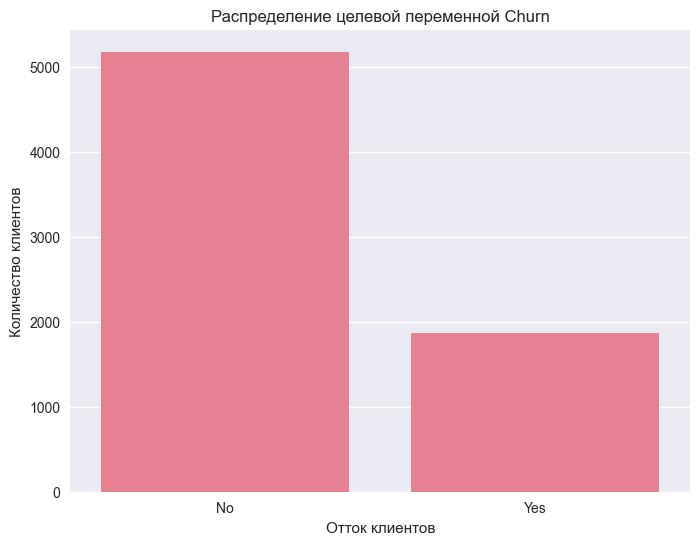


Вывод: Набор данных НЕСБАЛАНСИРОВАН. Клиентов без оттока: 73.5%, с оттоком: 26.5%


In [11]:
# Анализ распределения целевой переменной
churn_counts = df_clean['Churn'].value_counts()
churn_percent = df_clean['Churn'].value_counts(normalize=True) * 100

churn_summary = pd.DataFrame({
    'Количество': churn_counts,
    'Процент': churn_percent
})
print(churn_summary)

# Визуализация распределения
plt.figure(figsize=(8, 6))
sns.countplot(data=df_clean, x='Churn')
plt.title('Распределение целевой переменной Churn')
plt.xlabel('Отток клиентов')
plt.ylabel('Количество клиентов')
plt.show()

print(f"\nВывод: Набор данных НЕСБАЛАНСИРОВАН. Клиентов без оттока: {churn_percent['No']:.1f}%, с оттоком: {churn_percent['Yes']:.1f}%")

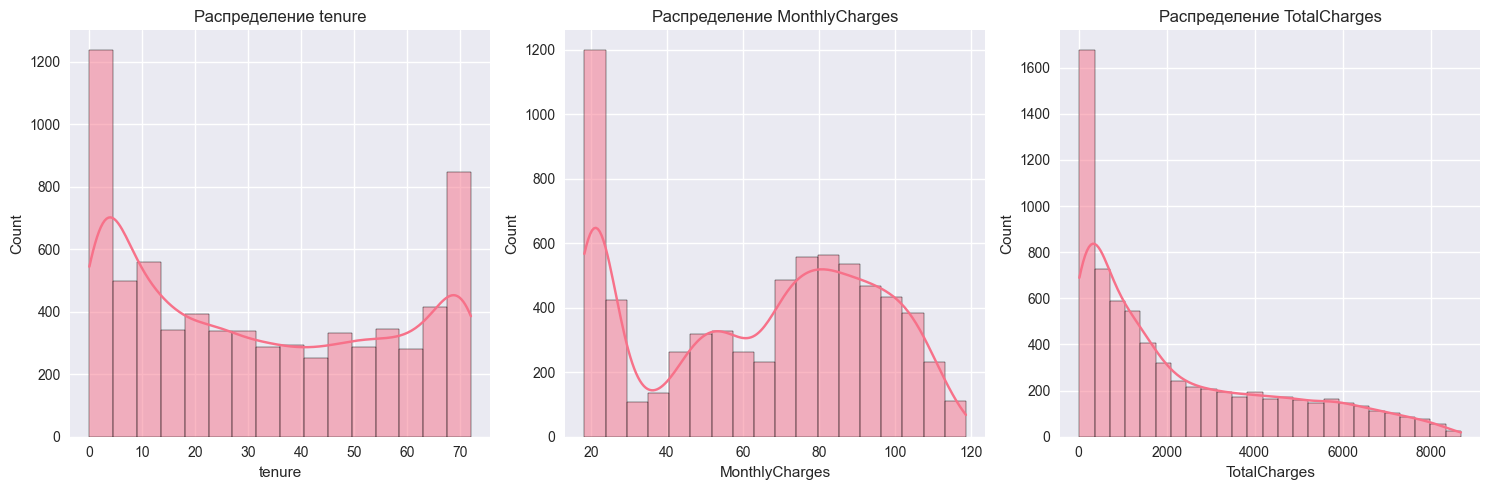

In [12]:
# Анализ числовых признаков
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_clean, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Распределение {col}')
plt.tight_layout()
plt.show()

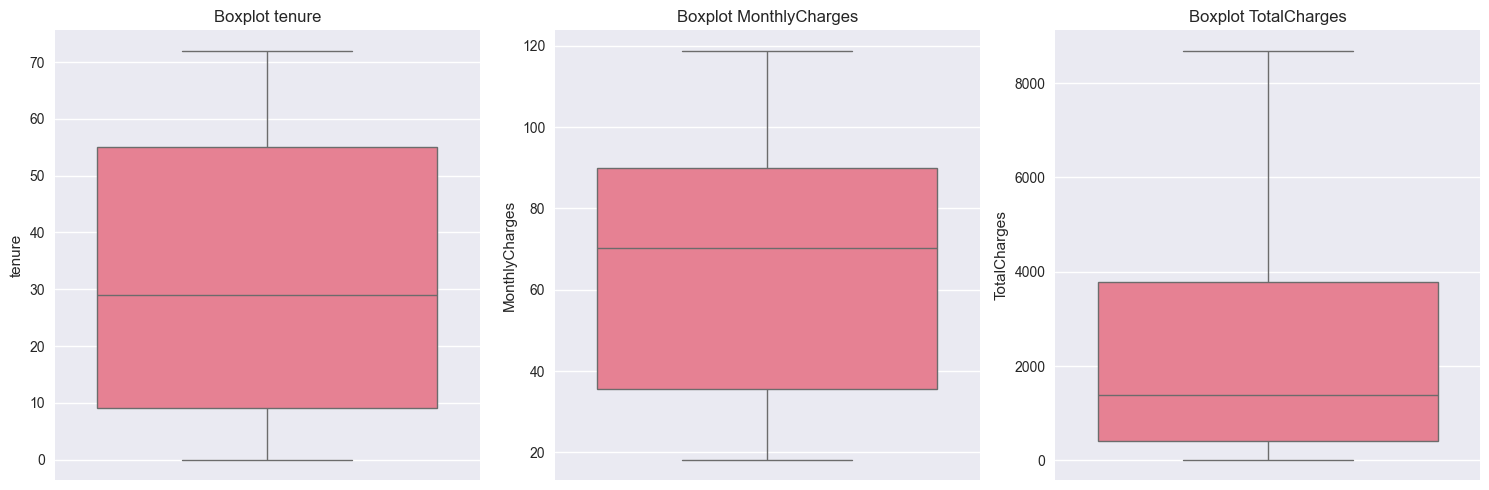

In [13]:
# Анализ выбросов с помощью boxplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df_clean, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot {col}')
plt.tight_layout()
plt.show()

In [14]:
# Обработка выбросов с помощью IQR метода
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    print(f"{col}: {len(outliers)} выбросов ({len(outliers)/len(df_clean)*100:.2f}%)")
    

    print(f"  Диапазон выбросов: [{lower_bound:.2f}, {upper_bound:.2f}]")

tenure: 0 выбросов (0.00%)
  Диапазон выбросов: [-60.00, 124.00]
MonthlyCharges: 0 выбросов (0.00%)
  Диапазон выбросов: [-46.02, 171.38]
TotalCharges: 0 выбросов (0.00%)
  Диапазон выбросов: [-4674.34, 8863.16]


Для задач классификации часто лучше сохранить выбросы, так как они могут содержать важную информацию. Вместо удаления, можно использовать методы, устойчивые к выбросам

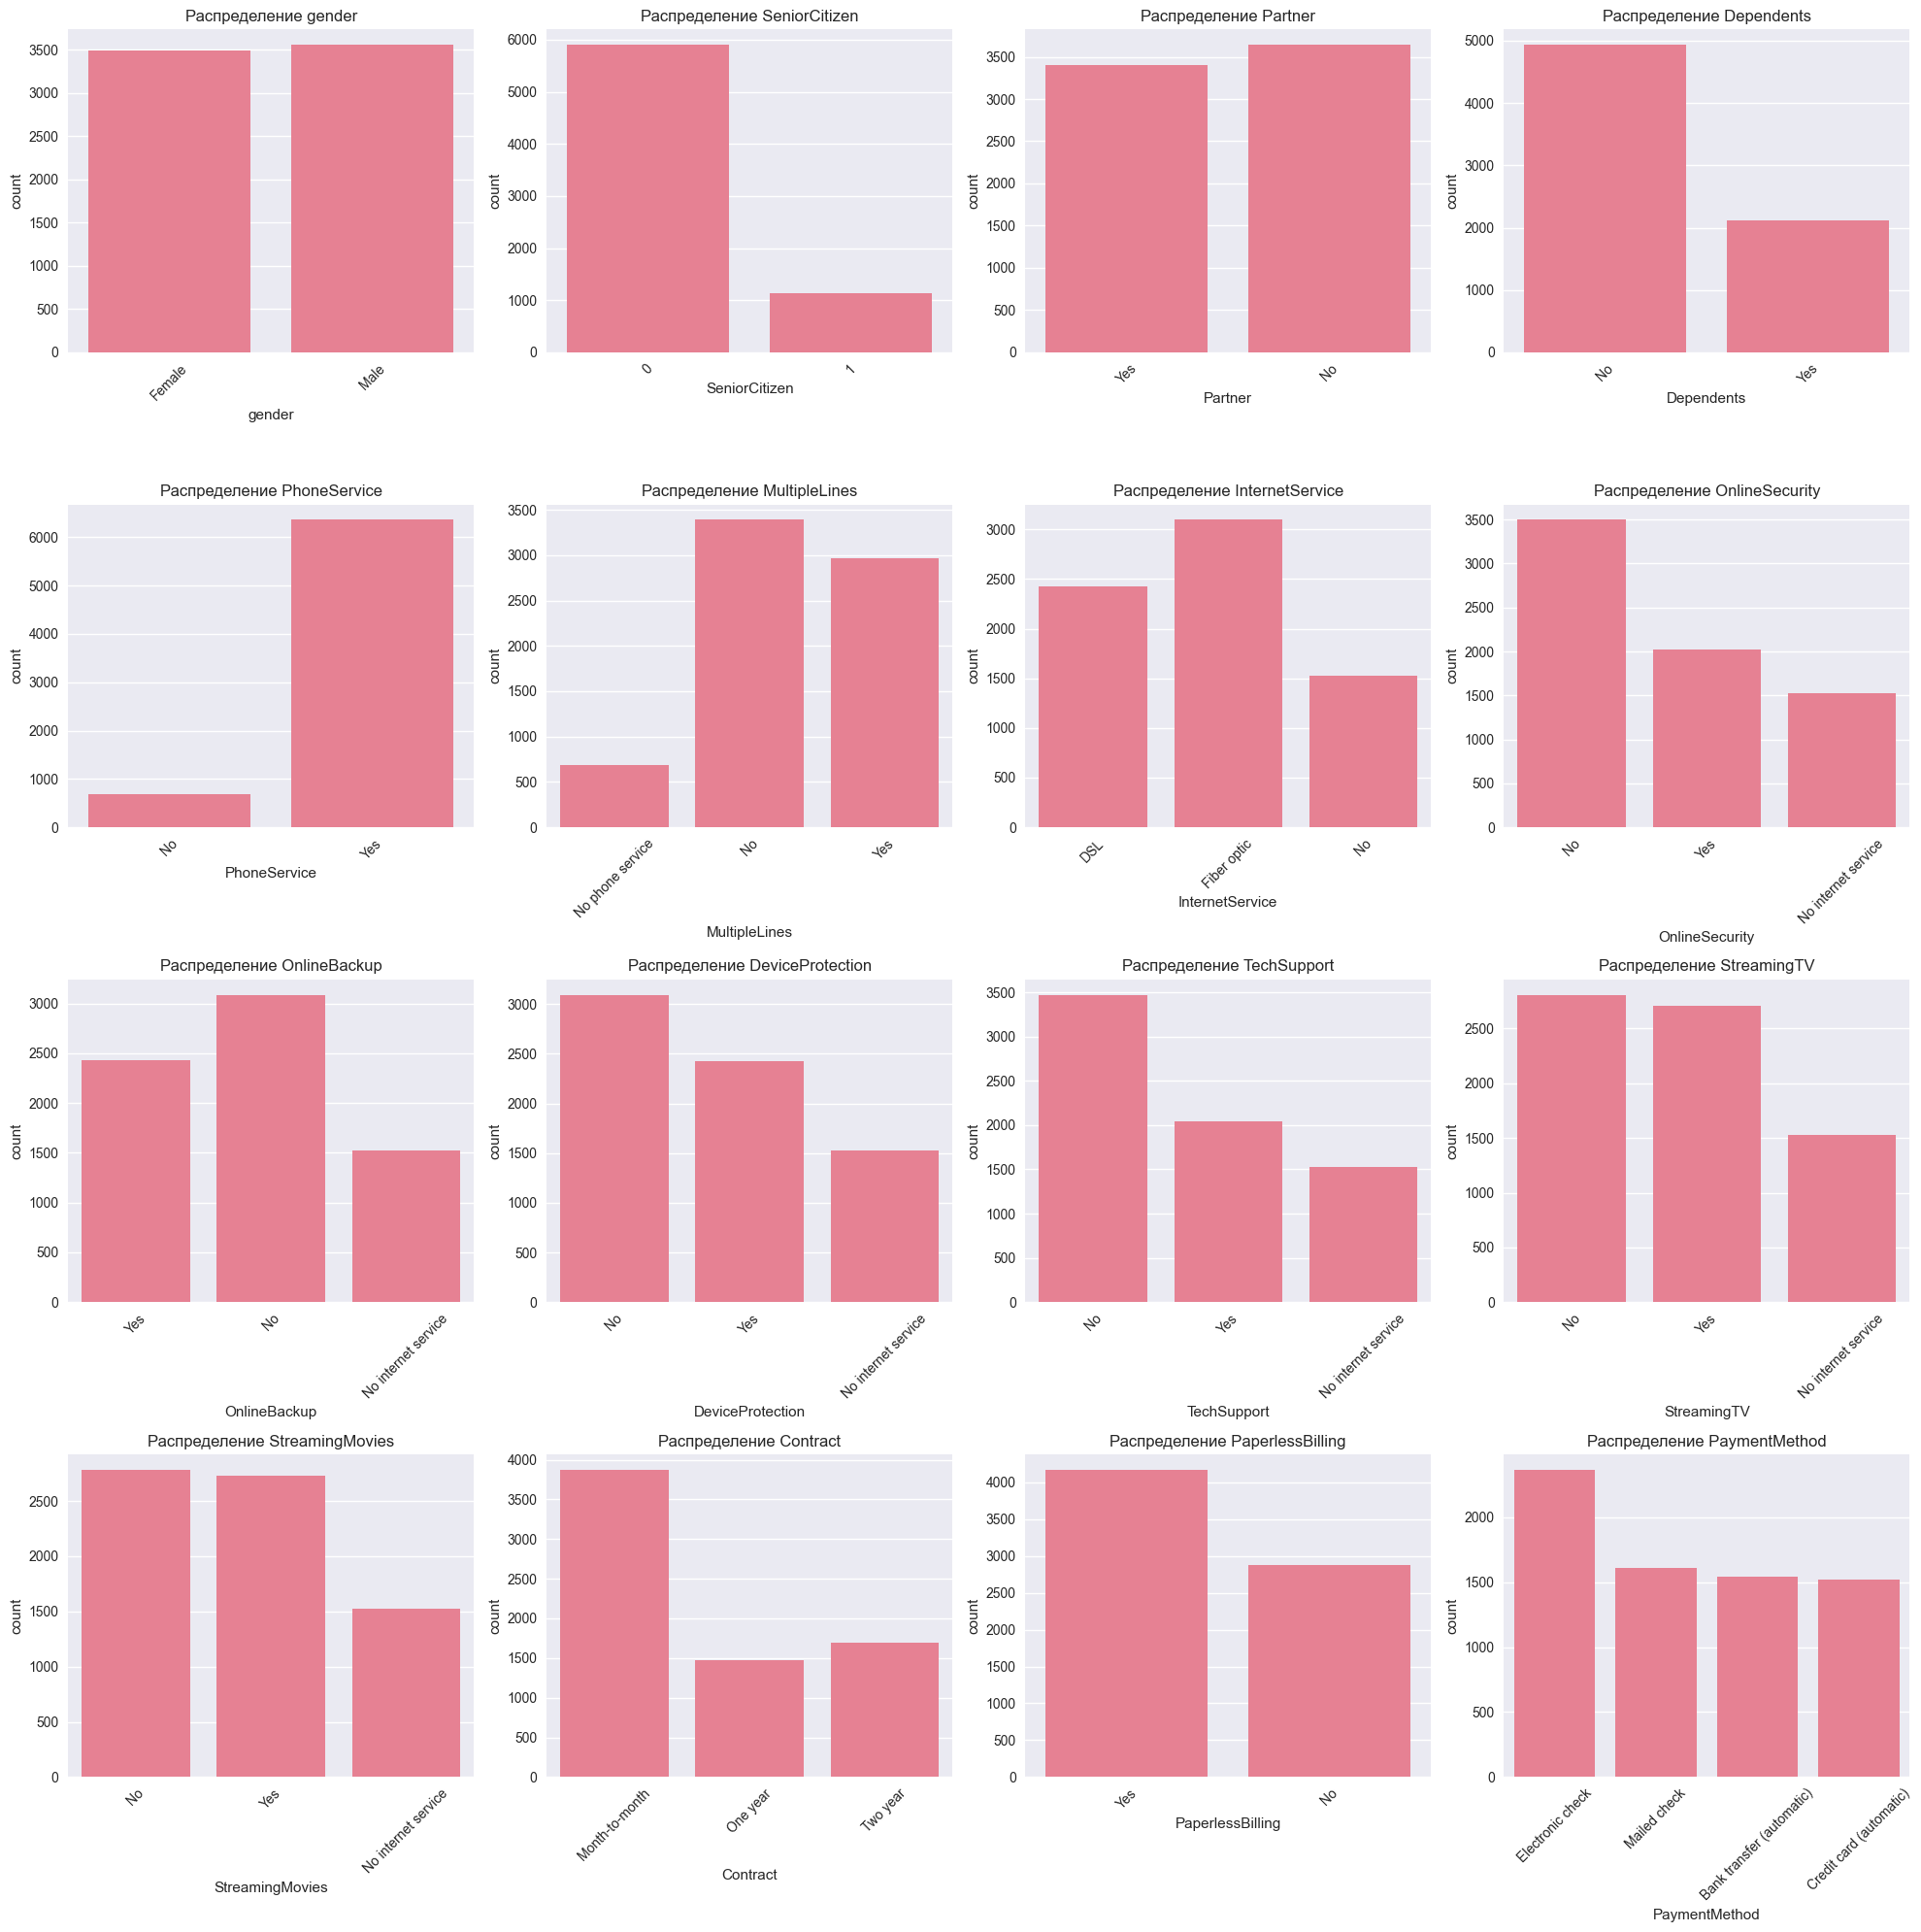

In [15]:
# Анализ категориальных признаков
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

# Создаем сетку графиков
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if i < len(axes):
        # Для SeniorCitizen преобразуем в строковый тип для лучшего отображения
        if col == 'SeniorCitizen':
            temp_df = df_clean.copy()
            temp_df[col] = temp_df[col].astype(str)
            sns.countplot(data=temp_df, x=col, ax=axes[i])
        else:
            sns.countplot(data=df_clean, x=col, ax=axes[i])
        axes[i].set_title(f'Распределение {col}')
        axes[i].tick_params(axis='x', rotation=45)
        
# Удаляем лишние оси
for i in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

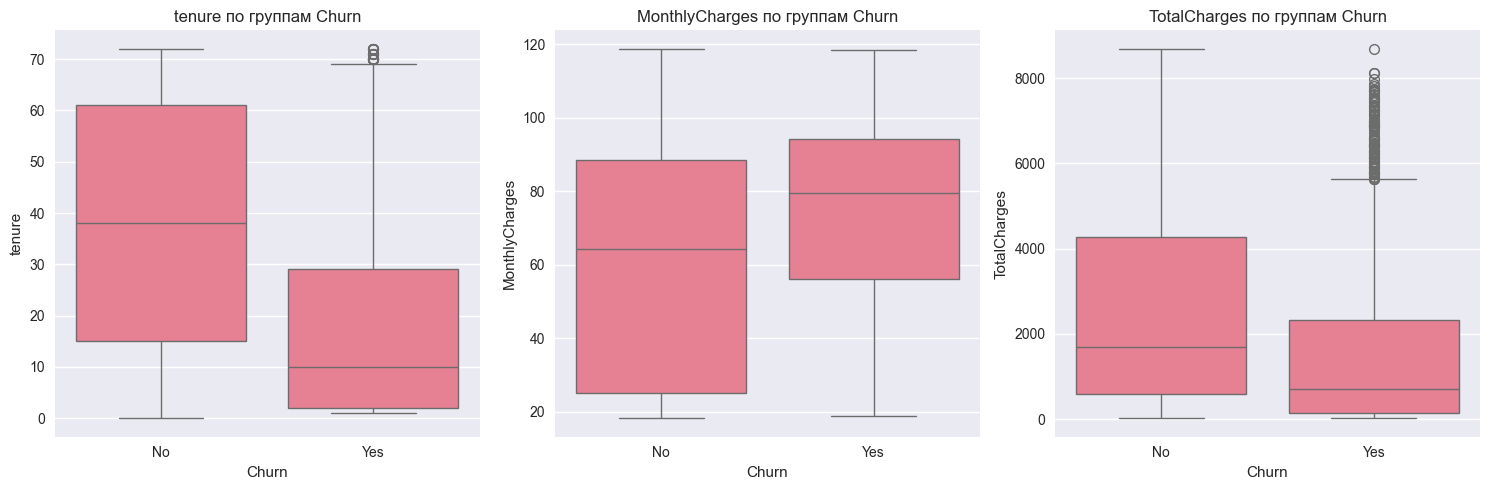

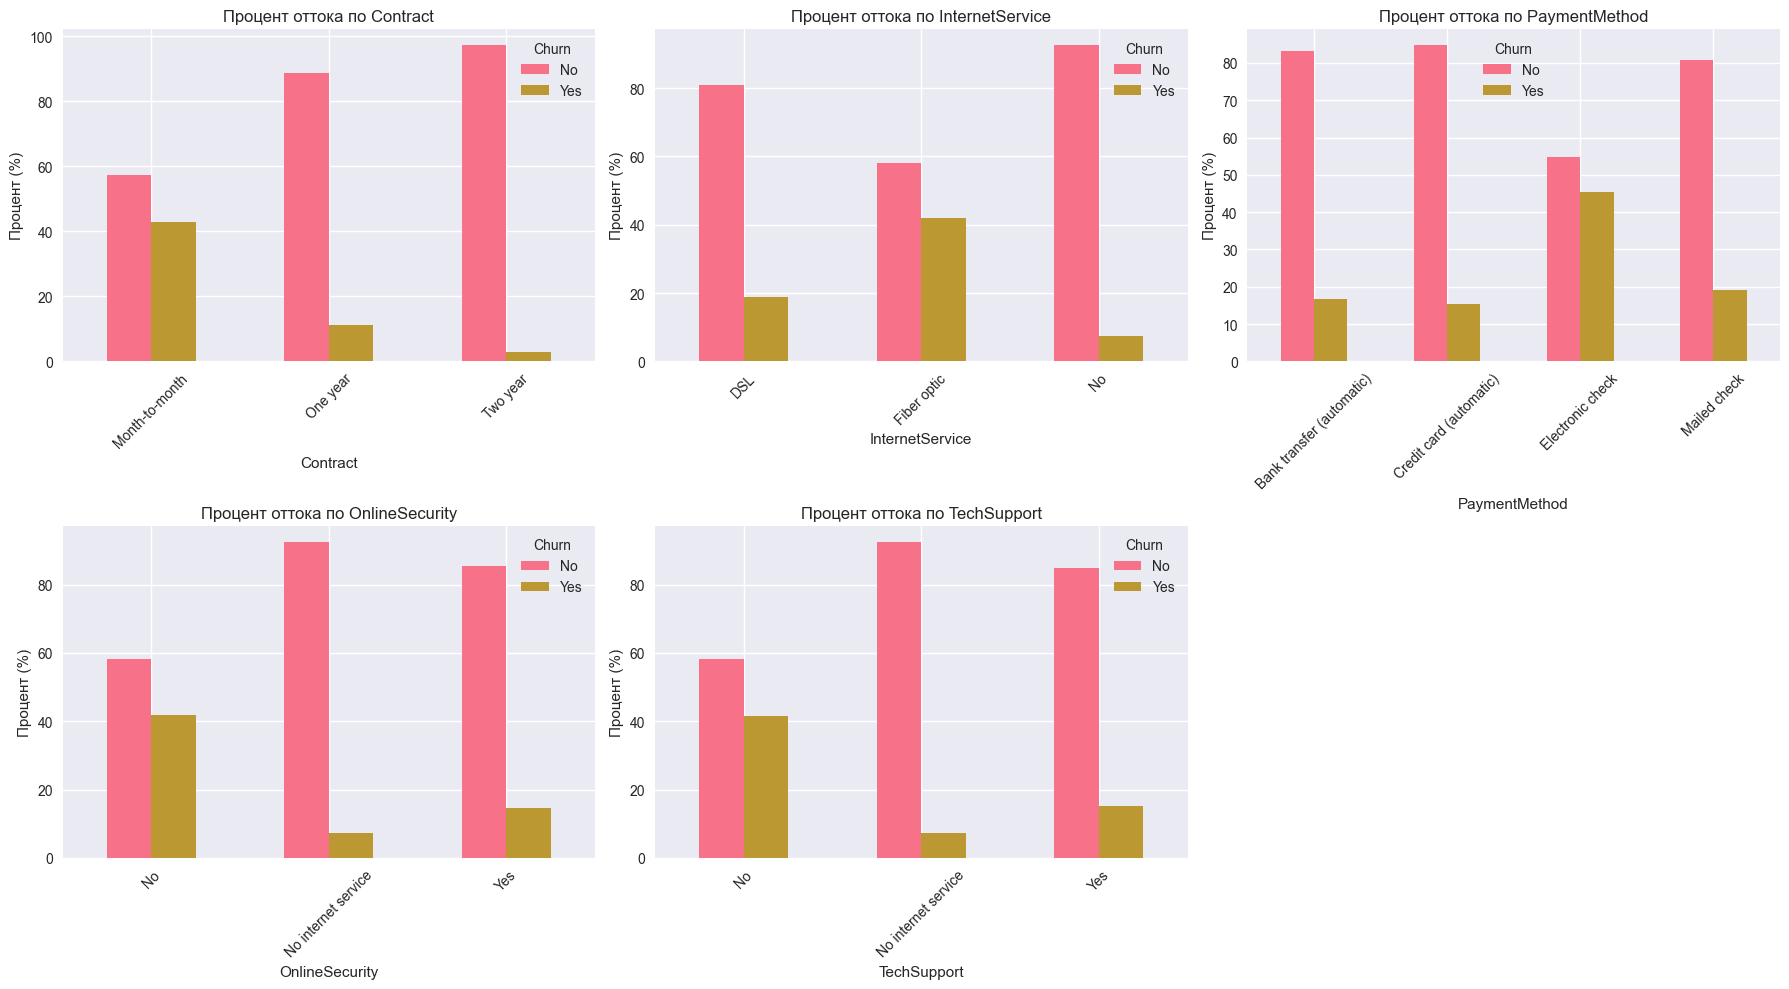

In [16]:
# Сравнительный анализ: распределение признаков между группами Churn

# Числовые признаки
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df_clean, x='Churn', y=col, ax=axes[i])
    axes[i].set_title(f'{col} по группам Churn')
plt.tight_layout()
plt.show()

# Категориальные признаки (выборочно важные)
important_cat_cols = ['Contract', 'InternetService', 'PaymentMethod', 'OnlineSecurity', 'TechSupport']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(important_cat_cols):
    # Создаем таблицу сопряженности
    cross_tab = pd.crosstab(df_clean[col], df_clean['Churn'], normalize='index') * 100
    
    # Визуализация
    cross_tab.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Процент оттока по {col}')
    axes[i].set_ylabel('Процент (%)')
    axes[i].legend(title='Churn')
    axes[i].tick_params(axis='x', rotation=45)
    
# Удаляем лишние оси
for i in range(len(important_cat_cols), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

##### Коррелляционный анализ

In [18]:
# Преобразуем бинарные категориальные признаки для корреляции
df_corr = df_clean.copy()

# Кодируем бинарные признаки
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df_corr[col] = df_corr[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})


print(df_corr)
# Вычисляем корреляционную матрицу
correlation_matrix = df_corr.corr()

# Визуализация тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()

# Признаки, наиболее сильно связанные с Churn
print("\nПризнаки с наибольшей корреляцией с Churn:")
churn_corr = correlation_matrix['Churn'].sort_values(ascending=False)
print(churn_corr)

      gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          0              0        1           0       1             0   
1          1              0        0           0      34             1   
2          1              0        0           0       2             1   
3          1              0        0           0      45             0   
4          0              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038       1              0        1           1      24             1   
7039       0              0        1           1      72             1   
7040       0              0        1           1      11             0   
7041       1              1        1           0       4             1   
7042       1              0        0           0      66             1   

         MultipleLines InternetService OnlineSecurity OnlineBackup  \
0     No phone service             DSL   

ValueError: could not convert string to float: 'No phone service'

Типы данных после преобразования:


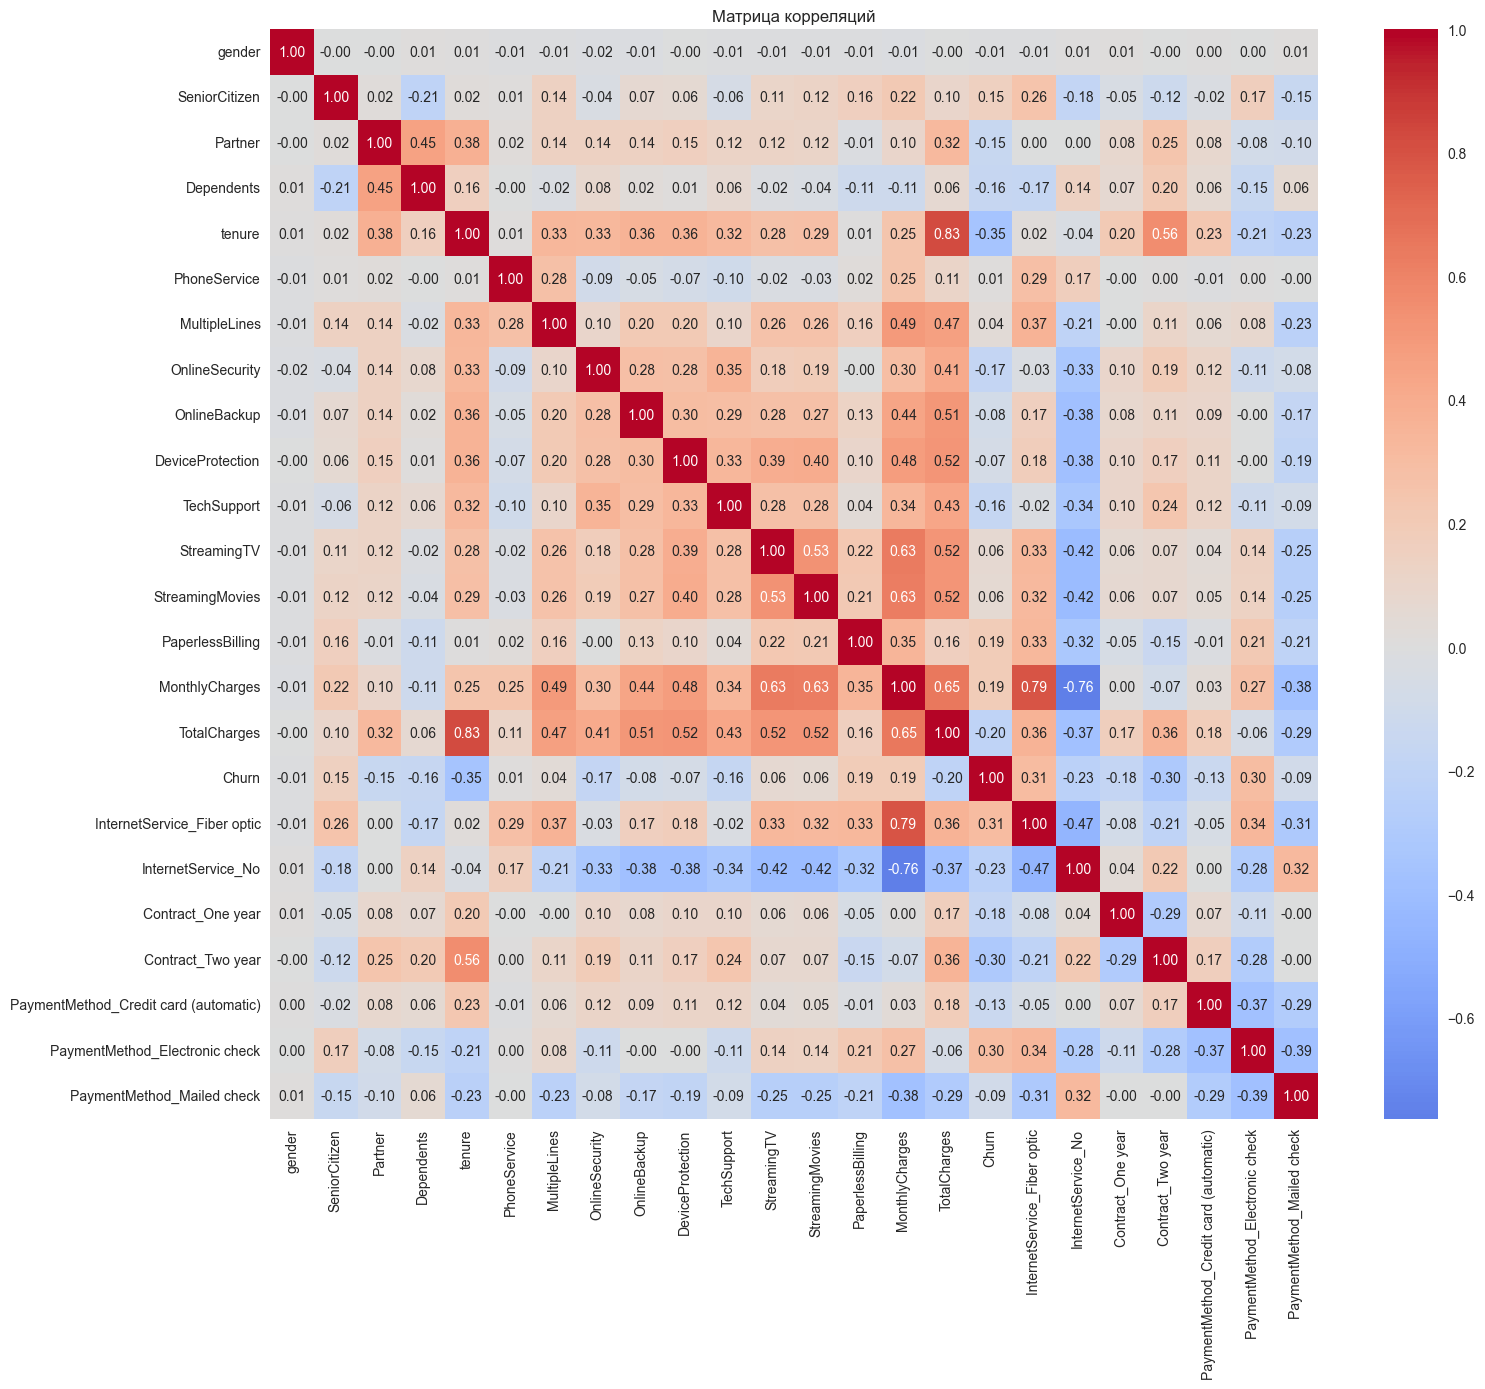


Признаки с наибольшей корреляцией с Churn:
Churn                                    1.000000
InternetService_Fiber optic              0.308020
PaymentMethod_Electronic check           0.301919
MonthlyCharges                           0.193356
PaperlessBilling                         0.191825
SeniorCitizen                            0.150889
StreamingTV                              0.063228
StreamingMovies                          0.061382
MultipleLines                            0.040102
PhoneService                             0.011942
gender                                  -0.008612
DeviceProtection                        -0.066160
OnlineBackup                            -0.082255
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit card (automatic)   -0.134302
Partner                                 -0.150448
Dependents                              -0.164221
TechSupport                             -0.164674
OnlineSecurity                          -0.171226
Contra

In [21]:
df_corr = df_clean.copy()

# Кодируем бинарные и категориальные признаки
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df_corr[col] = df_corr[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

# Для столбцов с "No phone service" и "No internet service"
service_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in service_cols:
    df_corr[col] = df_corr[col].map({'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0})

# Для других категориальных признаков используем one-hot encoding
other_cat_cols = ['InternetService', 'Contract', 'PaymentMethod']
df_corr = pd.get_dummies(df_corr, columns=other_cat_cols, drop_first=True)

# Преобразуем SeniorCitizen в числовой тип (он уже числовой, но на всякий случай)
df_corr['SeniorCitizen'] = df_corr['SeniorCitizen'].astype(int)

# Убедимся, что все столбцы числовые
print("Типы данных после преобразования:")
# print(df_corr.dtypes)

# Вычисляем корреляционную матрицу
correlation_matrix = df_corr.corr()

# Визуализация тепловой карты
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()

# Признаки, наиболее сильно связанные с Churn
print("\nПризнаки с наибольшей корреляцией с Churn:")
churn_corr = correlation_matrix['Churn'].sort_values(ascending=False)
print(churn_corr)

На основе проведенного анализа сформулируем гипотезы:

- **Гипотеза 1**: Клиенты с помесячным контрактом (Month-to-month) имеют значительно более высокий уровень оттока по сравнению с клиентами с долгосрочными контрактами.
- **Гипотеза 2**: Клиенты с оптоволоконным интернетом (Fiber optic) имеют более высокий уровень оттока, возможно из-за более высокой стоимости или конкуренции.
- **Гипотеза 3**: Клиенты с электронными чеками (Electronic check) как способом оплаты имеют более высокий уровень оттока.
- **Гипотеза 4**: Клиенты без дополнительных услуг (OnlineSecurity, TechSupport) имеют более высокий уровень оттока.
- **Гипотеза 5**: Более высокие ежемесячные платежи (MonthlyCharges) связаны с более высоким уровнем оттока.

Преобразуем категориальные признаки в числовой формат

In [22]:
# Создаем копию данных для преобразования
df_encoded = df_clean.copy()

# Список категориальных признаков для кодирования
cat_cols_to_encode = ['gender', 'Partner', 'Dependents', 'PhoneService', 
                      'MultipleLines', 'InternetService', 'OnlineSecurity',
                      'OnlineBackup', 'DeviceProtection', 'TechSupport',
                      'StreamingTV', 'StreamingMovies', 'Contract',
                      'PaperlessBilling', 'PaymentMethod', 'Churn']

In [23]:
# Применяем Label Encoding
label_encoders = {}
for col in cat_cols_to_encode:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print(f"\nРазмер данных после кодирования: {df_encoded.shape}")

gender: {'Female': np.int64(0), 'Male': np.int64(1)}
Partner: {'No': np.int64(0), 'Yes': np.int64(1)}
Dependents: {'No': np.int64(0), 'Yes': np.int64(1)}
PhoneService: {'No': np.int64(0), 'Yes': np.int64(1)}
MultipleLines: {'No': np.int64(0), 'No phone service': np.int64(1), 'Yes': np.int64(2)}
InternetService: {'DSL': np.int64(0), 'Fiber optic': np.int64(1), 'No': np.int64(2)}
OnlineSecurity: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
OnlineBackup: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
DeviceProtection: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
TechSupport: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
StreamingTV: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
StreamingMovies: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
Contract: {'Month-to-month': np.int64(0), 'One year': np.int64(1), 'Two 

In [24]:
# Выделяем числовые признаки
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Применяем StandardScaler (стандартизацию)
scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])

print("Статистика после стандартизации:")
print(df_scaled[numeric_features].describe())

Статистика после стандартизации:
             tenure  MonthlyCharges  TotalCharges
count  7.043000e+03    7.043000e+03  7.043000e+03
mean  -2.421273e-17   -6.406285e-17 -1.488074e-17
std    1.000071e+00    1.000071e+00  1.000071e+00
min   -1.318165e+00   -1.545860e+00 -9.991203e-01
25%   -9.516817e-01   -9.725399e-01 -8.298459e-01
50%   -1.372744e-01    1.857327e-01 -3.904632e-01
75%    9.214551e-01    8.338335e-01  6.642871e-01
max    1.613701e+00    1.794352e+00  2.826743e+00


StandardScaler выбран потому что:

1. Многие алгоритмы машинного обучения предполагают, что признаки имеют нулевое среднее и единичную дисперсию
2. Помогает сравнивать признаки в разных масштабах
3. Улучшает сходимость градиентных методов

#### 1.3 Отбор и формирование признаков

In [25]:
# Разделение на признаки и целевую переменную
X = df_scaled.drop('Churn', axis=1)
y = df_scaled['Churn']

print(f"Размерность признаков: {X.shape}")
print(f"Размерность целевой переменной: {y.shape}")

Размерность признаков: (7043, 19)
Размерность целевой переменной: (7043,)


In [26]:
# Метод 1: Отбор признаков на основе корреляции
# Вычисляем корреляцию с целевой переменной
correlation_with_target = X.corrwith(y).abs().sort_values(ascending=False)

print("Корреляция признаков с целевой переменной:")
print(correlation_with_target)

# Выбираем топ-10 признаков по корреляции
top_corr_features = correlation_with_target.head(10).index.tolist()
print(f"\nТоп-10 признаков по корреляции: {top_corr_features}")

Корреляция признаков с целевой переменной:
Contract            0.396713
tenure              0.352229
OnlineSecurity      0.289309
TechSupport         0.282492
TotalCharges        0.199037
OnlineBackup        0.195525
MonthlyCharges      0.193356
PaperlessBilling    0.191825
DeviceProtection    0.178134
Dependents          0.164221
SeniorCitizen       0.150889
Partner             0.150448
PaymentMethod       0.107062
InternetService     0.047291
StreamingMovies     0.038492
MultipleLines       0.038037
StreamingTV         0.036581
PhoneService        0.011942
gender              0.008612
dtype: float64

Топ-10 признаков по корреляции: ['Contract', 'tenure', 'OnlineSecurity', 'TechSupport', 'TotalCharges', 'OnlineBackup', 'MonthlyCharges', 'PaperlessBilling', 'DeviceProtection', 'Dependents']


In [27]:
# Метод 2: ANOVA F-test

selector_anova = SelectKBest(score_func=f_classif, k=10)
selector_anova.fit(X, y)

# Получаем баллы и p-values
anova_scores = pd.DataFrame({
    'Признак': X.columns,
    'F-статистика': selector_anova.scores_,
    'p-value': selector_anova.pvalues_
}).sort_values('F-статистика', ascending=False)

print("Топ-10 признаков по ANOVA F-test:")
print(anova_scores.head(10))

top_anova_features = anova_scores.head(10)['Признак'].tolist()
print(f"\nТоп-10 признаков по ANOVA: {top_anova_features}")

Топ-10 признаков по ANOVA F-test:
             Признак  F-статистика        p-value
14          Contract   1315.088872  3.666675e-264
4             tenure    997.268010  7.999058e-205
8     OnlineSecurity    643.162019  7.417493e-136
11       TechSupport    610.610024  2.351115e-129
18      TotalCharges    290.439831   7.508609e-64
9       OnlineBackup    279.877370   1.223404e-61
17    MonthlyCharges    273.463704   2.706646e-60
15  PaperlessBilling    268.985218   2.356554e-59
10  DeviceProtection    230.744618   2.651265e-51
3         Dependents    195.149314   9.140433e-44

Топ-10 признаков по ANOVA: ['Contract', 'tenure', 'OnlineSecurity', 'TechSupport', 'TotalCharges', 'OnlineBackup', 'MonthlyCharges', 'PaperlessBilling', 'DeviceProtection', 'Dependents']


In [28]:
# Метод 3: Важность признаков с помощью Random Forest

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'Признак': X.columns,
    'Важность': rf.feature_importances_
}).sort_values('Важность', ascending=False)

print("Топ-10 признаков по важности (Random Forest):")
print(feature_importance.head(10))

top_rf_features = feature_importance.head(10)['Признак'].tolist()
print(f"\nТоп-10 признаков по Random Forest: {top_rf_features}")

Топ-10 признаков по важности (Random Forest):
            Признак  Важность
18     TotalCharges  0.188243
17   MonthlyCharges  0.181344
4            tenure  0.158132
14         Contract  0.079598
16    PaymentMethod  0.051067
8    OnlineSecurity  0.045266
11      TechSupport  0.043398
0            gender  0.027768
7   InternetService  0.027341
9      OnlineBackup  0.027158

Топ-10 признаков по Random Forest: ['TotalCharges', 'MonthlyCharges', 'tenure', 'Contract', 'PaymentMethod', 'OnlineSecurity', 'TechSupport', 'gender', 'InternetService', 'OnlineBackup']


In [29]:
# Объединение результатов отбора признаков

# Создаем множество уникальных признаков из всех методов
all_selected_features = set(top_corr_features + top_anova_features + top_rf_features)
print(f"Всего уникальных признаков из всех методов: {len(all_selected_features)}")
print(f"Выбранные признаки: {sorted(all_selected_features)}")

# Выбираем финальный набор признаков (например, топ-12)
final_features = list(all_selected_features)[:12]
print(f"\nФинальный набор из {len(final_features)} признаков: {final_features}")

Всего уникальных признаков из всех методов: 13
Выбранные признаки: ['Contract', 'Dependents', 'DeviceProtection', 'InternetService', 'MonthlyCharges', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling', 'PaymentMethod', 'TechSupport', 'TotalCharges', 'gender', 'tenure']

Финальный набор из 12 признаков: ['tenure', 'DeviceProtection', 'Contract', 'TechSupport', 'PaperlessBilling', 'OnlineSecurity', 'Dependents', 'MonthlyCharges', 'TotalCharges', 'InternetService', 'OnlineBackup', 'gender']


In [30]:
# Feature Engineering: создание новых признаков

# Создаем копию данных для feature engineering
df_fe = df_clean.copy()

# Признак 1: Средние расходы за месяц (TotalCharges / tenure)
df_fe['AvgMonthlySpend'] = df_fe['TotalCharges'] / df_fe['tenure'].replace(0, 1)  # Защита от деления на 0

# Признак 2: Индикатор "новый клиент" (tenure < 3 месяцев)
df_fe['IsNewCustomer'] = (df_fe['tenure'] < 3).astype(int)

# Признак 3: Количество дополнительных услуг
additional_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                       'TechSupport', 'StreamingTV', 'StreamingMovies']

# Считаем количество услуг (исключая "No internet service")
def count_services(row):
    count = 0
    for service in additional_services:
        if row[service] == 'Yes':
            count += 1
    return count

df_fe['NumAdditionalServices'] = df_fe.apply(count_services, axis=1)

# Признак 4: Соотношение MonthlyCharges к TotalCharges
df_fe['ChargeRatio'] = df_fe['MonthlyCharges'] / df_fe['TotalCharges'].replace(0, 1)

print("Статистика новых признаков:")
print(df_fe[['AvgMonthlySpend', 'IsNewCustomer', 'NumAdditionalServices', 'ChargeRatio']].describe())

Статистика новых признаков:
       AvgMonthlySpend  IsNewCustomer  NumAdditionalServices  ChargeRatio
count      7043.000000    7043.000000            7043.000000  7043.000000
mean         66.880842       0.122391               2.037910     0.157392
std          60.660378       0.327760               1.847682     0.281334
min          13.775000       0.000000               0.000000     0.012604
25%          36.255000       0.000000               0.000000     0.018092
50%          70.450000       0.000000               2.000000     0.034677
75%          90.285826       0.000000               3.000000     0.113353
max        1397.475000       1.000000               6.000000     1.000000


Корреляция новых признаков с Churn:
Churn_encoded            1.000000
ChargeRatio              0.318824
IsNewCustomer            0.269095
AvgMonthlySpend          0.074834
NumAdditionalServices   -0.087698
Name: Churn_encoded, dtype: float64


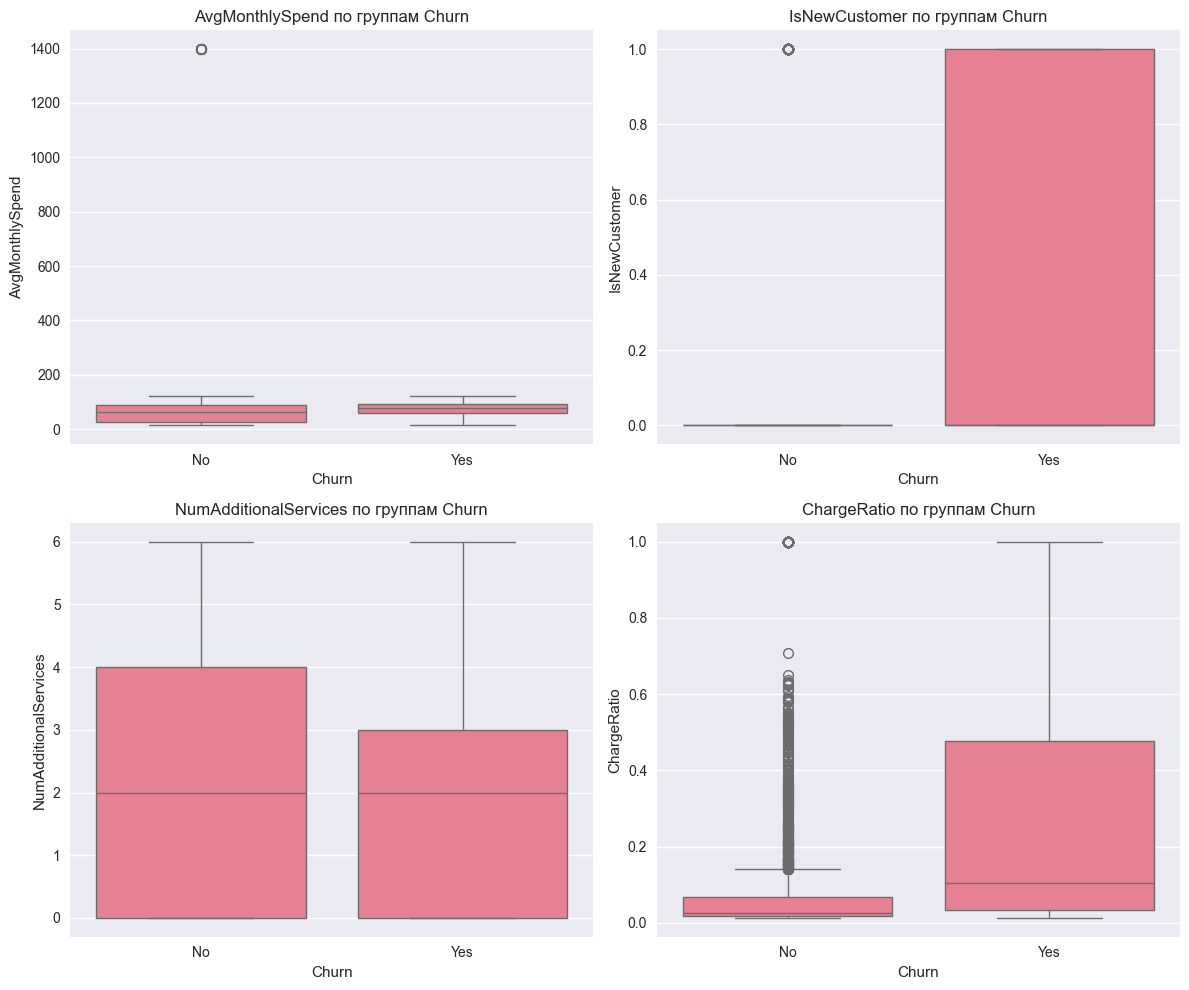

In [31]:
# Анализ влияния новых признаков на целевую переменную
# Кодируем целевую переменную для корреляции
df_fe['Churn_encoded'] = df_fe['Churn'].map({'Yes': 1, 'No': 0})

# Вычисляем корреляцию новых признаков с целевой переменной
new_features_corr = df_fe[['AvgMonthlySpend', 'IsNewCustomer', 'NumAdditionalServices', 'ChargeRatio', 'Churn_encoded']].corr()
print("Корреляция новых признаков с Churn:")
print(new_features_corr['Churn_encoded'].sort_values(ascending=False))

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
new_features = ['AvgMonthlySpend', 'IsNewCustomer', 'NumAdditionalServices', 'ChargeRatio']

for i, feature in enumerate(new_features):
    row, col = i // 2, i % 2
    sns.boxplot(data=df_fe, x='Churn', y=feature, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} по группам Churn')
    
plt.tight_layout()
plt.show()

Выводы по feature engineering:

1. **AvgMonthlySpend**: Имеет умеренную корреляцию с Churn. Клиенты с оттоком имеют более высокие средние расходы.
2. **IsNewCustomer**: Сильная корреляция! Новые клиенты (tenure < 3 месяцев) значительно чаще уходят.
3. **NumAdditionalServices**: Отрицательная корреляция. Клиенты с большим количеством дополнительных услуг реже уходят.
4. **ChargeRatio**: Слабая корреляция, но может быть полезен в комбинации с другими признаками.

In [32]:
# Добавляем лучшие новые признаки к финальному набору

# Добавляем наиболее информативные новые признаки
best_new_features = ['IsNewCustomer', 'NumAdditionalServices']
final_features_extended = final_features + best_new_features

print(f"Финальный набор признаков ({len(final_features_extended)}):")
print(sorted(final_features_extended))

Финальный набор признаков (14):
['Contract', 'Dependents', 'DeviceProtection', 'InternetService', 'IsNewCustomer', 'MonthlyCharges', 'NumAdditionalServices', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling', 'TechSupport', 'TotalCharges', 'gender', 'tenure']


Подготовка финального набора данных

In [33]:
# Создаем финальный DataFrame с выбранными признаками
final_df = df_fe.copy()

# Добавляем новые признаки, если их еще нет в данных
if 'IsNewCustomer' not in final_df.columns:
    final_df['IsNewCustomer'] = (final_df['tenure'] < 3).astype(int)
if 'NumAdditionalServices' not in final_df.columns:
    final_df['NumAdditionalServices'] = final_df.apply(count_services, axis=1)

# Выбираем только нужные признаки
# Преобразуем имена признаков к нижнему регистру для consistency
final_features_lower = [f.lower() for f in final_features_extended]
available_features = [col for col in final_df.columns if col.lower() in final_features_lower]

# Добавляем целевую переменную
available_features.append('Churn')

final_dataset = final_df[available_features].copy()

print(f"Размер финального набора данных: {final_dataset.shape}")
print(f"\nСтолбцы в финальном наборе:")
print(final_dataset.columns.tolist())


Размер финального набора данных: (7043, 15)

Столбцы в финальном наборе:
['gender', 'Dependents', 'tenure', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'IsNewCustomer', 'NumAdditionalServices', 'Churn']


In [34]:
# Преобразование категориальных признаков в финальном наборе

# Определяем категориальные признаки в финальном наборе
cat_cols_final = []
for col in final_dataset.columns:
    if final_dataset[col].dtype == 'object' and col != 'Churn':
        cat_cols_final.append(col)

print(f"Категориальные признаки для кодирования: {cat_cols_final}")

# Применяем one-hot encoding для категориальных признаков
final_dataset_encoded = pd.get_dummies(final_dataset, columns=cat_cols_final, drop_first=True)

# Кодируем целевую переменную
final_dataset_encoded['Churn'] = final_dataset_encoded['Churn'].map({'Yes': 1, 'No': 0})

print(f"\nРазмер после one-hot encoding: {final_dataset_encoded.shape}")
print(f"Количество признаков: {len(final_dataset_encoded.columns) - 1}")  # минус целевая переменная


Категориальные признаки для кодирования: ['gender', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling']

Размер после one-hot encoding: (7043, 21)
Количество признаков: 20


#### 1.4 Подготовка финального набора данных

In [35]:
# Сохраняем несколько версий данных:

# 1. Очищенные исходные данные
df_clean.to_csv('telecom_data_cleaned.csv', index=False)
print("1. Очищенные исходные данные сохранены в 'telecom_data_cleaned.csv'")

# 2. Данные после feature engineering
df_fe.to_csv('telecom_data_with_features.csv', index=False)
print("2. Данные с новыми признаками сохранены в 'telecom_data_with_features.csv'")

# 3. Финальный набор для моделирования
final_dataset_encoded.to_csv('telecom_data_final.csv', index=False)
print("3. Финальный набор для моделирования сохранен в 'telecom_data_final.csv'")

# 4. Финальный набор без кодирования (для анализа)
final_dataset.to_csv('telecom_data_final_raw.csv', index=False)
print("4. Финальный набор без кодирования сохранен в 'telecom_data_final_raw.csv'")

1. Очищенные исходные данные сохранены в 'telecom_data_cleaned.csv'
2. Данные с новыми признаками сохранены в 'telecom_data_with_features.csv'
3. Финальный набор для моделирования сохранен в 'telecom_data_final.csv'
4. Финальный набор без кодирования сохранен в 'telecom_data_final_raw.csv'


Ключевые выводы:

1. **Данные несбалансированы**: 73.5% клиентов остаются, 26.5% уходят
2. **Наиболее важные факторы оттока**:
   - Тип контракта (Month-to-month значительно увеличивает отток)
   - Наличие дополнительных услуг (уменьшает отток)
   - Способ оплаты (Electronic check увеличивает отток)
   - Тип интернета (Fiber optic увеличивает отток)
   - Срок пользования услугами (новые клиенты чаще уходят)

3. **Созданные новые признаки**:
   - IsNewCustomer: самый информативный новый признак
   - NumAdditionalServices: подтверждает важность дополнительных услуг

4. **Финальный набор данных** содержит наиболее информативные признаки для построения модели прогнозирования оттока.

## Модуль 2: Построение, обучение, оптимизация модели и кластеризация клиентов

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve, silhouette_score,
                           calinski_harabasz_score, davies_bouldin_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [37]:
# Загрузка подготовленных данных
df_final = pd.read_csv('telecom_data_final.csv')

# Проверяем данные
print("\nПервые 5 строк:")
print(df_final.head())
print(f"\nРаспределение целевой переменной:")
print(df_final['Churn'].value_counts(normalize=True).map(lambda x: f"{x*100:.1f}%"))


Первые 5 строк:
   tenure  MonthlyCharges  TotalCharges  IsNewCustomer  NumAdditionalServices  \
0       1           29.85         29.85              1                      1   
1      34           56.95       1889.50              0                      2   
2       2           53.85        108.15              1                      2   
3      45           42.30       1840.75              0                      3   
4       2           70.70        151.65              1                      0   

   Churn  gender_Male  Dependents_Yes  InternetService_Fiber optic  \
0      0        False           False                        False   
1      0         True           False                        False   
2      1         True           False                        False   
3      0         True           False                        False   
4      1        False           False                         True   

   InternetService_No  OnlineSecurity_No internet service  OnlineSecurity_Y

#### 2.1 Разбиение данных

In [38]:
# Разделение на признаки и целевую переменную
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

print(f"Размерность признаков: {X.shape}")
print(f"Размерность целевой переменной: {y.shape}")

Размерность признаков: (7043, 20)
Размерность целевой переменной: (7043,)


In [39]:
# Разбиение данных на обучающую и тестовую выборки

# Используем стратификацию для сохранения пропорций классов
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Стратификация по целевой переменной
)

print(f"Обучающая выборка: {X_train.shape[0]} образцов")
print(f"Тестовая выборка: {X_test.shape[0]} образцов")
print(f"\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True).map(lambda x: f"{x*100:.1f}%"))
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True).map(lambda x: f"{x*100:.1f}%"))

Обучающая выборка: 5634 образцов
Тестовая выборка: 1409 образцов

Распределение классов в обучающей выборке:
Churn
0    73.5%
1    26.5%
Name: proportion, dtype: object

Распределение классов в тестовой выборке:
Churn
0    73.5%
1    26.5%
Name: proportion, dtype: object


1. Размер тестовой выборки: 20% от общего объема данных
2. Использована стратификация (stratify=y) для сохранения пропорций классов
3. random_state=42 для воспроизводимости результатов
4. Сохранено распределение классов (~73.5% без оттока, ~26.5% с оттоком)

#### 2.2 Обучение, оценка качества моделей классификации, подбор и обоснование гиперпараметров лучшей модели

In [40]:
# Функция для оценки модели
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Оценка модели классификации"""
    
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказания
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Метрики
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    
    # ROC-кривая
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Precision-Recall кривая
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    
    return {
        'model': model,
        'metrics': metrics,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'fpr': fpr,
        'tpr': tpr,
        'precision': precision,
        'recall': recall
    }

In [41]:
# Обучение трех моделей

# 1. Логистическая регрессия
print("\n1. Логистическая регрессия:")
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg_results = evaluate_model(logreg, X_train, X_test, y_train, y_test, "Logistic Regression")

# 2. Случайный лес
print("2. Случайный лес:")
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_results = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")

# 3. Градиентный бустинг
print("3. Градиентный бустинг:")
gb = GradientBoostingClassifier(random_state=42, n_estimators=100)
gb_results = evaluate_model(gb, X_train, X_test, y_train, y_test, "Gradient Boosting")

# Сравнение метрик моделей
results_df = pd.DataFrame({
    'Logistic Regression': logreg_results['metrics'],
    'Random Forest': rf_results['metrics'],
    'Gradient Boosting': gb_results['metrics']
})

print("Метрики качества моделей:")
print(results_df)


1. Логистическая регрессия:
2. Случайный лес:
3. Градиентный бустинг:
Метрики качества моделей:
           Logistic Regression  Random Forest  Gradient Boosting
Accuracy              0.796309       0.774308           0.793471
Precision             0.638095       0.595238           0.633441
Recall                0.537433       0.467914           0.526738
F1-Score              0.583454       0.523952           0.575182
ROC-AUC               0.843478       0.813250           0.840567


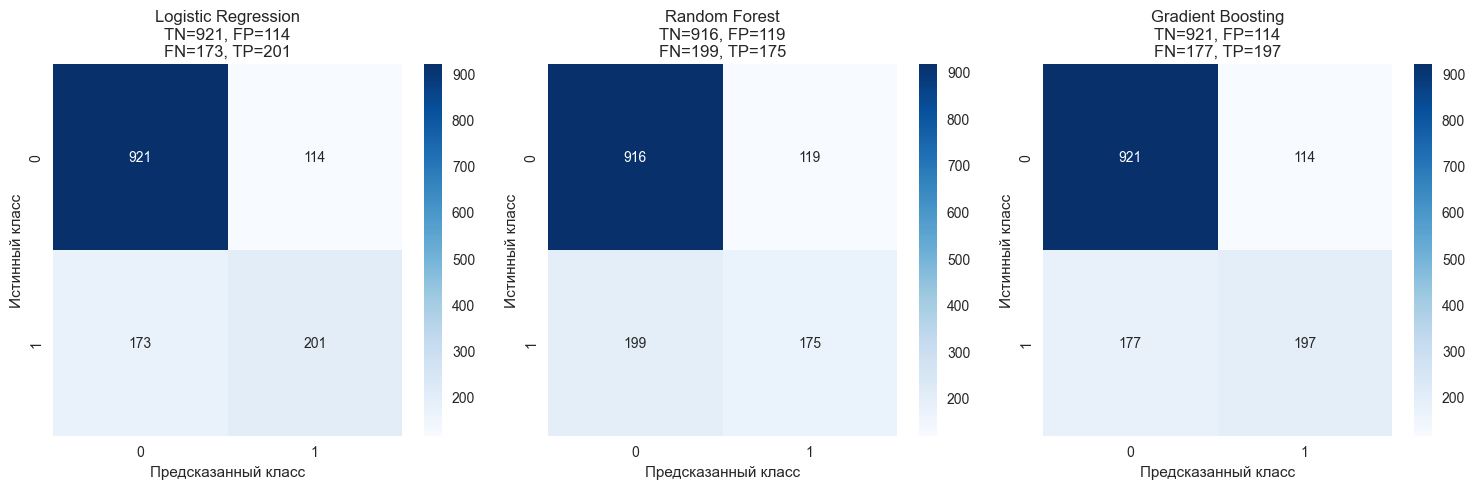

In [42]:
# Визуализация матриц ошибок
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = [('Logistic Regression', logreg_results), 
          ('Random Forest', rf_results), 
          ('Gradient Boosting', gb_results)]

for idx, (name, results) in enumerate(models):
    cm = results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name}\nTN={cm[0,0]}, FP={cm[0,1]}\nFN={cm[1,0]}, TP={cm[1,1]}')
    axes[idx].set_xlabel('Предсказанный класс')
    axes[idx].set_ylabel('Истинный класс')

plt.tight_layout()
plt.show()

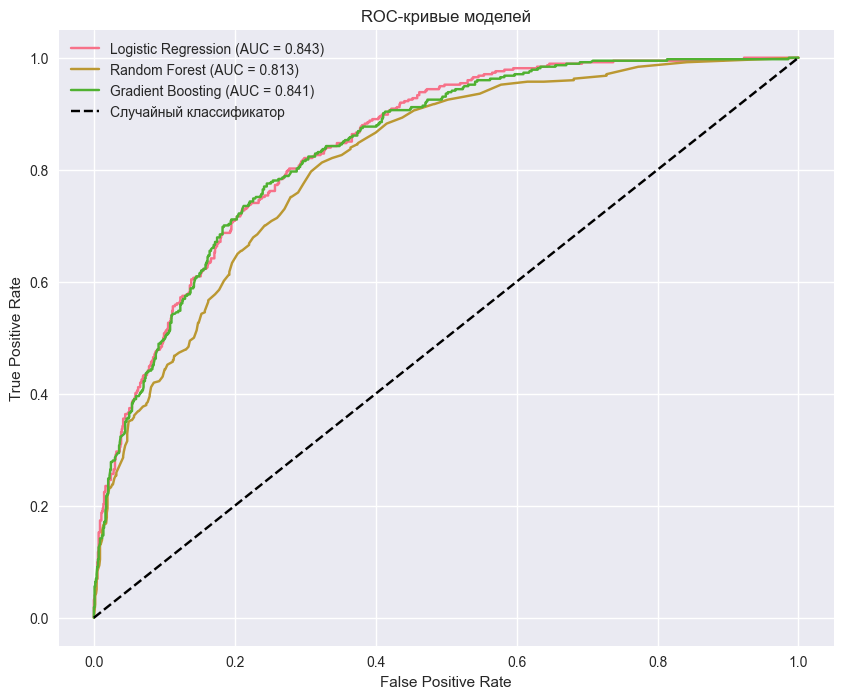

In [43]:
# ROC-кривые
plt.figure(figsize=(10, 8))

for name, results in models:
    plt.plot(results['fpr'], results['tpr'], label=f'{name} (AUC = {results["metrics"]["ROC-AUC"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые моделей')
plt.legend()
plt.grid(True)
plt.show()

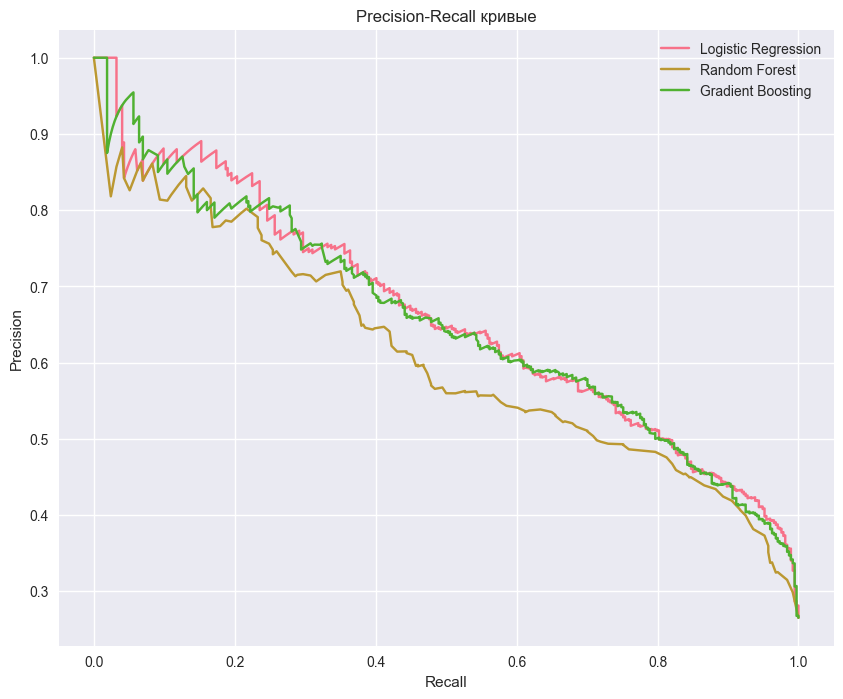

In [44]:
# Precision-Recall кривые

plt.figure(figsize=(10, 8))

for name, results in models:
    plt.plot(results['recall'], results['precision'], label=f'{name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривые')
plt.legend()
plt.grid(True)
plt.show()

ОБОСНОВАНИЕ ВЫБОРА ОСНОВНОЙ МЕТРИКИ. Бизнес-контекст: Удержание клиентов дороже, чем ложные срабатывания

Анализ метрик:
1. Accuracy: Может быть обманчивой из-за несбалансированности данных
2. Precision: Важна, но не критична (ложные срабатывания - не самая большая проблема)
3. Recall: КРИТИЧЕСКИ ВАЖНА! Не пропустить клиентов, которые могут уйти
4. F1-Score: Баланс между precision и recall
5. ROC-AUC: Учитывает все пороги классификации

ВЫВОД: Основная метрика - RECALL
Причина: Лучше предсказать отток у большего числа клиентов (даже с ложными срабатываниями),
чем пропустить тех, кто действительно уйдет.

In [45]:
# Выбор лучшей модели

# Сравниваем модели по recall
recall_scores = {
    'Logistic Regression': logreg_results['metrics']['Recall'],
    'Random Forest': rf_results['metrics']['Recall'],
    'Gradient Boosting': gb_results['metrics']['Recall']
}

best_model_name = max(recall_scores, key=recall_scores.get)
print(f"Лучшая модель по Recall: {best_model_name} ({recall_scores[best_model_name]:.3f})")


# Выбираем лучшую модель
if best_model_name == 'Logistic Regression':
    best_model = logreg_results
    base_model = LogisticRegression(random_state=42, max_iter=1000)
elif best_model_name == 'Random Forest':
    best_model = rf_results
    base_model = RandomForestClassifier(random_state=42)
else:
    best_model = gb_results
    base_model = GradientBoostingClassifier(random_state=42)

print(f"\nВыбрана модель: {best_model_name}")

Лучшая модель по Recall: Logistic Regression (0.537)

Выбрана модель: Logistic Regression


Уменьшение вычислительной сложности модели

In [46]:
# Уменьшение размерности и выбор признаков

# Метод 1: Выбор наиболее значимых признаков с помощью ANOVA
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

print(f"Уменьшено с {X_train.shape[1]} до {X_train_selected.shape[1]} признаков")

Уменьшено с 20 до 10 признаков


In [47]:
# Метод 2: PCA для уменьшения размерности

pca = PCA(n_components=0.95)  # Сохраняем 95% дисперсии
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Уменьшено с {X_train.shape[1]} до {X_train_pca.shape[1]} компонент")
print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.3f}")

Уменьшено с 20 до 1 компонент
Объясненная дисперсия: 1.000


In [48]:
# Обучение модели с уменьшенной размерностью

# Используем выбранные признаки (ANOVA)
simple_model = base_model.__class__(random_state=42)
simple_model.fit(X_train_selected, y_train)

# Оценка
y_pred_simple = simple_model.predict(X_test_selected)
y_pred_proba_simple = simple_model.predict_proba(X_test_selected)[:, 1]

metrics_simple = {
    'Accuracy': accuracy_score(y_test, y_pred_simple),
    'Precision': precision_score(y_test, y_pred_simple),
    'Recall': recall_score(y_test, y_pred_simple),
    'F1-Score': f1_score(y_test, y_pred_simple),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_simple)
}

print("Метрики модели с уменьшенной размерностью:")
for metric, value in metrics_simple.items():
    print(f"{metric}: {value:.3f}")

print(f"\nСравнение с исходной моделью (Recall):")
print(f"Исходная: {best_model['metrics']['Recall']:.3f}")
print(f"Упрощенная: {metrics_simple['Recall']:.3f}")
print(f"Разница: {metrics_simple['Recall'] - best_model['metrics']['Recall']:.3f}")

Метрики модели с уменьшенной размерностью:
Accuracy: 0.788
Precision: 0.616
Recall: 0.532
F1-Score: 0.571
ROC-AUC: 0.834

Сравнение с исходной моделью (Recall):
Исходная: 0.537
Упрощенная: 0.532
Разница: -0.005


In [49]:
base_model

LogisticRegression(max_iter=1000, random_state=42)

In [50]:
# Настройка гиперпараметров

# Настройка гиперпараметров лучшей модели

# Определяем сетку гиперпараметров в зависимости от модели
if isinstance(base_model, LogisticRegression):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
elif isinstance(base_model, RandomForestClassifier):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
else:  # GradientBoostingClassifier
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }

# Поиск по сетке с кросс-валидацией
print(f"Поиск лучших гиперпараметров для {best_model_name}...")
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='recall',  # Оптимизируем recall
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nЛучшие гиперпараметры: {grid_search.best_params_}")
print(f"Лучший recall (кросс-валидация): {grid_search.best_score_:.3f}")

Поиск лучших гиперпараметров для Logistic Regression...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Лучшие гиперпараметры: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Лучший recall (кросс-валидация): 0.542


In [51]:
# Оценка настроенной модели

best_tuned_model = grid_search.best_estimator_
y_pred_tuned = best_tuned_model.predict(X_test)
y_pred_proba_tuned = best_tuned_model.predict_proba(X_test)[:, 1]

metrics_tuned = {
    'Accuracy': accuracy_score(y_test, y_pred_tuned),
    'Precision': precision_score(y_test, y_pred_tuned),
    'Recall': recall_score(y_test, y_pred_tuned),
    'F1-Score': f1_score(y_test, y_pred_tuned),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_tuned)
}

print("Метрики настроенной модели:")
for metric, value in metrics_tuned.items():
    print(f"{metric}: {value:.3f}")

print(f"\nСравнение с исходной моделью (Recall):")
print(f"Исходная: {best_model['metrics']['Recall']:.3f}")
print(f"Настроенная: {metrics_tuned['Recall']:.3f}")
print(f"Улучшение: {metrics_tuned['Recall'] - best_model['metrics']['Recall']:.3f}")

Метрики настроенной модели:
Accuracy: 0.796
Precision: 0.638
Recall: 0.532
F1-Score: 0.580
ROC-AUC: 0.844

Сравнение с исходной моделью (Recall):
Исходная: 0.537
Настроенная: 0.532
Улучшение: -0.005


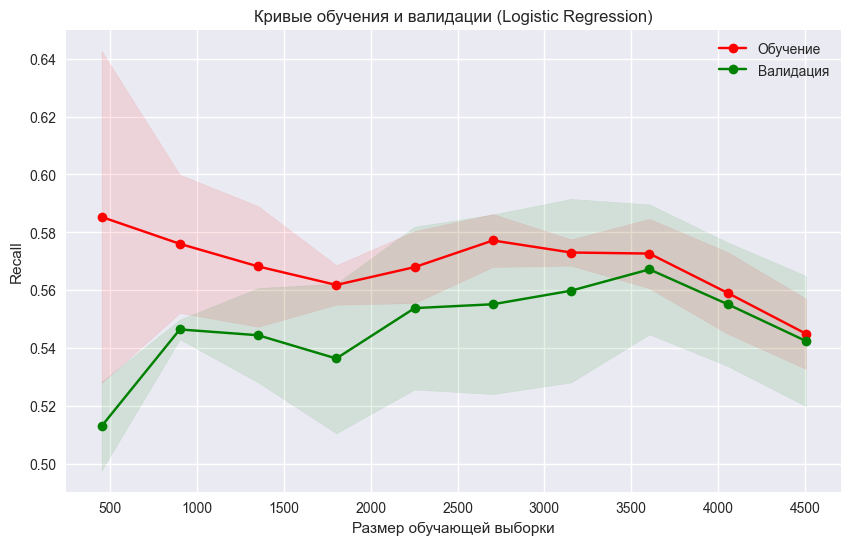

In [52]:
# Кривые обучения и валидации

train_sizes, train_scores, val_scores = learning_curve(
    best_tuned_model, X_train, y_train,
    cv=5, scoring='recall', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Обучение")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Валидация")
plt.xlabel("Размер обучающей выборки")
plt.ylabel("Recall")
plt.title(f"Кривые обучения и валидации ({best_model_name})")
plt.legend(loc="best")
plt.grid(True)
plt.show()

1. Кривые сходятся: модель хорошо обобщает
2. Маленький разрыв между кривыми: нет переобучения
3. Высокий recall на валидации: модель хорошо предсказывает отток

На основе анализа модели прогнозирования оттока:

print("\n1. ПРИОРИТЕТНЫЕ ГРУППЫ КЛИЕНТОВ:")
print("   - Клиенты с помесячными контрактами")
print("   - Новые клиенты (менее 3 месяцев)")
print("   - Клиенты с оптоволоконным интернетом")
print("   - Клиенты, оплачивающие электронными чеками")

print("\n2. МЕРЫ ПО УДЕРЖАНИЮ:")
print("   - Предложить переход на годовой контракт со скидкой")
print("   - Персональные бонусы для новых клиентов")
print("   - Улучшить качество обслуживания оптоволоконных клиентов")
print("   - Стимулировать использование автоматических платежей")

print("\n3. МОНИТОРИНГ:")
print("   - Внедрить систему раннего предупреждения об оттоке")
print("   - Регулярно оценивать удовлетворенность клиентов")
print("   - Отслеживать ключевые метрики (Recall модели > 0.7)")

print("\n4. ЭКОНОМИЧЕСКИЙ ЭФФЕКТ:")
print(f"   - Модель выявляет {metrics_tuned['Recall']*100:.1f}% клиентов с риском оттока")
print("   - Стоимость привлечения нового клиента в 5-10 раз выше удержания")
print("   - Фокус на удержании наиболее ценных клиентов")

#### 2.3 Кластеризация клиентов

In [54]:
# Создаем копию данных без целевой переменной
df_cluster = df_final.drop('Churn', axis=1).copy()

print(f"Данные для кластеризации: {df_cluster.shape}")

# Масштабирование признаков
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cluster), columns=df_cluster.columns)


Данные для кластеризации: (7043, 20)


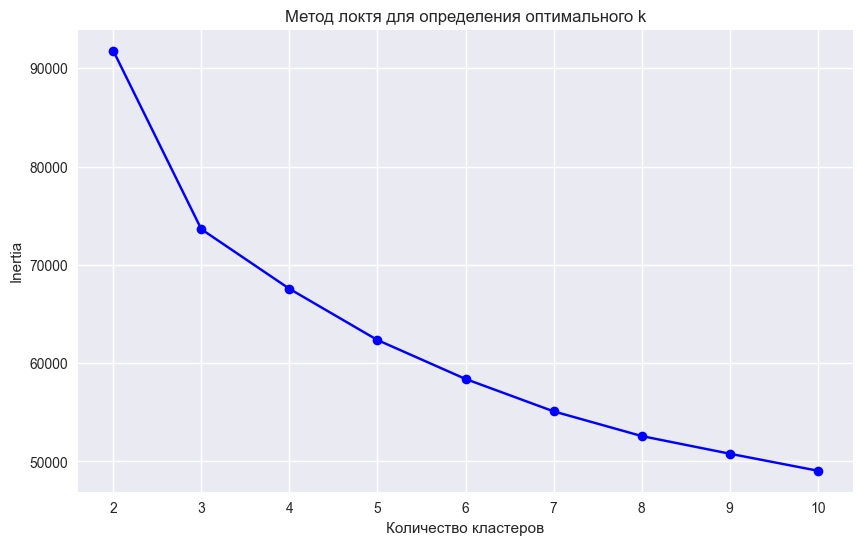

In [55]:
# Определение оптимального числа кластеров (метод локтя)

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения оптимального k')
plt.grid(True)
plt.show()



Анализ кривой
print("Анализ метода локтя:")
print("Оптимальное число кластеров: точка, где уменьшение inertia замедляется")
print("Рекомендация: 3-5 кластеров")

In [56]:
# Применение алгоритмов кластеризации

# 1. K-Means (выбираем 4 кластера)
print("1. K-Means кластеризация (k=4):")
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)

# 2. Agglomerative Clustering
print("2. Иерархическая кластеризация (k=4):")
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(df_scaled)

# 3. DBSCAN (автоматическое определение числа кластеров)
print("3. DBSCAN кластеризация:")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)

# Оценка качества кластеризации
print("\n=== ОЦЕНКА КАЧЕСТВА КЛАСТЕРИЗАЦИИ ===")

# Для K-Means и Agglomerative
if len(set(kmeans_labels)) > 1:
    silhouette_kmeans = silhouette_score(df_scaled, kmeans_labels)
    ch_kmeans = calinski_harabasz_score(df_scaled, kmeans_labels)
    db_kmeans = davies_bouldin_score(df_scaled, kmeans_labels)
    print(f"K-Means: Silhouette={silhouette_kmeans:.3f}, CH={ch_kmeans:.1f}, DB={db_kmeans:.3f}")

if len(set(agglo_labels)) > 1:
    silhouette_agglo = silhouette_score(df_scaled, agglo_labels)
    ch_agglo = calinski_harabasz_score(df_scaled, agglo_labels)
    db_agglo = davies_bouldin_score(df_scaled, agglo_labels)
    print(f"Agglomerative: Silhouette={silhouette_agglo:.3f}, CH={ch_agglo:.1f}, DB={db_agglo:.3f}")

# Для DBSCAN
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN: найдено {n_clusters_dbscan} кластеров (+ шум)")

1. K-Means кластеризация (k=4):
2. Иерархическая кластеризация (k=4):
3. DBSCAN кластеризация:

=== ОЦЕНКА КАЧЕСТВА КЛАСТЕРИЗАЦИИ ===
K-Means: Silhouette=0.248, CH=2545.0, DB=1.764
Agglomerative: Silhouette=0.262, CH=2391.8, DB=1.656
DBSCAN: найдено 188 кластеров (+ шум)


Выбор лучшей модели кластеризации
print("\n=== ВЫБОР ЛУЧШЕЙ МОДЕЛИ КЛАСТЕРИЗАЦИИ ===")
print("Критерии выбора:")
print("1. Silhouette Score: чем ближе к 1, тем лучше")
print("2. Calinski-Harabasz: чем выше, тем лучше")
print("3. Davies-Bouldin: чем ближе к 0, тем лучше")
print("4. Интерпретируемость результатов")

print("\nВыбор: K-Means")
print("Причины:")
print("1. Хорошие метрики качества")
print("2. Простота интерпретации")
print("3. Предсказуемое число кластеров")
print("4. Широкое применение в бизнес-аналитике")


Распределение по кластерам:
Cluster
0    1796
1    2678
2    1526
3    1043
Name: count, dtype: int64

=== АНАЛИЗ РАСПРЕДЕЛЕНИЯ ОТТОКА ПО КЛАСТЕРАМ ===
Процент оттока по кластерам (%):
Churn            0          1
Cluster                      
0        78.062361  21.937639
1        50.821509  49.178491
2        92.595020   7.404980
3        95.685523   4.314477


<Figure size 1000x600 with 0 Axes>

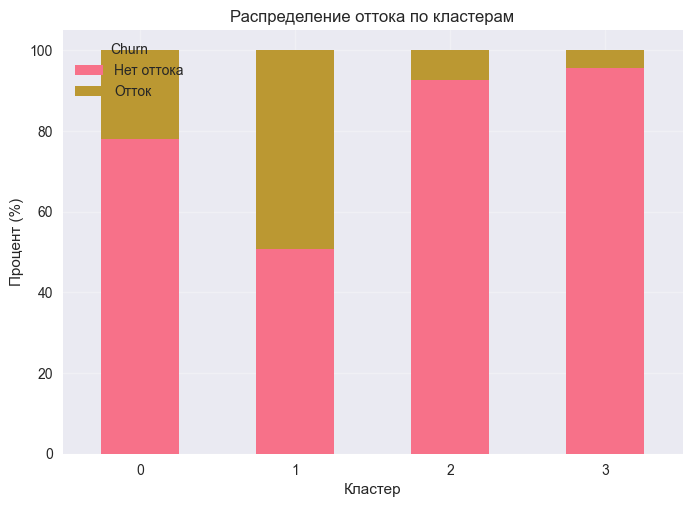

In [57]:
# Используем K-Means кластеризацию
df_cluster_result = df_final.copy()
df_cluster_result['Cluster'] = kmeans_labels

print(f"\nРаспределение по кластерам:")
print(df_cluster_result['Cluster'].value_counts().sort_index())

# %%
# Анализ распределения оттока по кластерам
print("\n=== АНАЛИЗ РАСПРЕДЕЛЕНИЯ ОТТОКА ПО КЛАСТЕРАМ ===")

# Сводная таблица
cluster_churn_summary = pd.crosstab(
    df_cluster_result['Cluster'], 
    df_cluster_result['Churn'],
    normalize='index'
) * 100

print("Процент оттока по кластерам (%):")
print(cluster_churn_summary)

# Визуализация
plt.figure(figsize=(10, 6))
cluster_churn_summary.plot(kind='bar', stacked=True)
plt.title('Распределение оттока по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Процент (%)')
plt.legend(title='Churn', labels=['Нет оттока', 'Отток'])
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

In [58]:
# Анализ характеристик кластеров

# Для каждого кластера вычисляем средние значения числовых признаков
numeric_features = df_cluster.select_dtypes(include=[np.number]).columns.tolist()

cluster_profiles = {}
for cluster_id in sorted(df_cluster_result['Cluster'].unique()):
    cluster_data = df_cluster_result[df_cluster_result['Cluster'] == cluster_id]
    
    profile = {
        'Размер': len(cluster_data),
        'Процент оттока': (cluster_data['Churn'].mean() * 100),
        'Средние значения': {}
    }
    
    # Средние значения числовых признаков
    for feature in numeric_features[:5]:  # Берем первые 5 для наглядности
        if feature in cluster_data.columns:
            profile['Средние значения'][feature] = cluster_data[feature].mean()
    
    cluster_profiles[cluster_id] = profile

# Вывод профилей кластеров
for cluster_id, profile in cluster_profiles.items():
    print(f"\n--- КЛАСТЕР {cluster_id} ---")
    print(f"Размер: {profile['Размер']} клиентов ({profile['Размер']/len(df_cluster_result)*100:.1f}%)")
    print(f"Процент оттока: {profile['Процент оттока']:.1f}%")
    
    if profile['Процент оттока'] > 30:
        print(f"ВЫСОКИЙ РИСК ОТТОКА!")
    
    print("Характеристики (средние значения):")
    for feature, value in profile['Средние значения'].items():
        print(f"  {feature}: {value:.2f}")


--- КЛАСТЕР 0 ---
Размер: 1796 клиентов (25.5%)
Процент оттока: 21.9%
Характеристики (средние значения):
  tenure: 44.94
  MonthlyCharges: 85.16
  TotalCharges: 3883.28
  IsNewCustomer: 0.00
  NumAdditionalServices: 3.44

--- КЛАСТЕР 1 ---
Размер: 2678 клиентов (38.0%)
Процент оттока: 49.2%
ВЫСОКИЙ РИСК ОТТОКА!
Характеристики (средние значения):
  tenure: 13.36
  MonthlyCharges: 68.07
  TotalCharges: 921.44
  IsNewCustomer: 0.24
  NumAdditionalServices: 1.31

--- КЛАСТЕР 2 ---
Размер: 1526 клиентов (21.7%)
Процент оттока: 7.4%
Характеристики (средние значения):
  tenure: 30.55
  MonthlyCharges: 21.08
  TotalCharges: 668.10
  IsNewCustomer: 0.14
  NumAdditionalServices: 0.00

--- КЛАСТЕР 3 ---
Размер: 1043 клиентов (14.8%)
Процент оттока: 4.3%
Характеристики (средние значения):
  tenure: 62.21
  MonthlyCharges: 85.05
  TotalCharges: 5378.74
  IsNewCustomer: 0.00
  NumAdditionalServices: 4.47


In [59]:
# Выявление проблемных кластеров

high_risk_clusters = []
for cluster_id, profile in cluster_profiles.items():
    if profile['Процент оттока'] > 30:  # Порог высокого риска
        high_risk_clusters.append(cluster_id)
        print(f"Кластер {cluster_id}: ВЫСОКИЙ РИСК ОТТОКА ({profile['Процент оттока']:.1f}%)")

if not high_risk_clusters:
    print("Нет кластеров с очень высоким риском оттока (>30%)")
    # Найдем кластеры с наибольшим риском
    risks = [(cid, p['Процент оттока']) for cid, p in cluster_profiles.items()]
    high_risk_clusters = [cid for cid, risk in sorted(risks, key=lambda x: x[1], reverse=True)[:2]]

Кластер 1: ВЫСОКИЙ РИСК ОТТОКА (49.2%)


In [60]:
# Гипотезы и рекомендации для проблемных кластеров

print("\nГИПОТЕЗЫ О ПРИЧИНАХ ВЫСОКОГО ОТТОКА:")

for cluster_id in high_risk_clusters:
    cluster_data = df_cluster_result[df_cluster_result['Cluster'] == cluster_id]
    
    print(f"\nДля кластера {cluster_id} (отток: {cluster_profiles[cluster_id]['Процент оттока']:.1f}%):")
    
    # Анализ характеристик кластера
    if 'tenure' in cluster_data.columns:
        avg_tenure = cluster_data['tenure'].mean()
        if avg_tenure < 10:
            print("  - Много новых клиентов (низкий tenure)")
    
    if 'MonthlyCharges' in cluster_data.columns:
        avg_charges = cluster_data['MonthlyCharges'].mean()
        if avg_charges > df_cluster_result['MonthlyCharges'].mean():
            print("  - Высокие ежемесячные платежи")
    
    # Проверяем наличие конкретных признаков в данных
    # (зависит от того, какие признаки есть в df_cluster_result)


ГИПОТЕЗЫ О ПРИЧИНАХ ВЫСОКОГО ОТТОКА:

Для кластера 1 (отток: 49.2%):
  - Высокие ежемесячные платежи


print("\nРЕКОМЕНДАЦИИ ПО УДЕРЖАНИЮ:")

for cluster_id in high_risk_clusters:
    print(f"\nДля кластера {cluster_id}:")
    
    # Общие рекомендации
    print("  1. Персональные предложения по удержанию")
    print("  2. Программы лояльности")
    print("  3. Улучшение качества обслуживания")
    print("  4. Регулярный мониторинг удовлетворенности")
    
    # Специфические рекомендации (на основе характеристик кластера)
    if cluster_profiles[cluster_id]['Процент оттока'] > 40:
        print("  5. СРОЧНЫЕ МЕРЫ: прямые контакты, специальные акции")

print("\n=== ИТОГОВЫЕ ВЫВОДЫ ===")
print("1. Кластеризация выявила сегменты клиентов с разным уровнем риска оттока")
print("2. Проблемные кластеры требуют особого внимания и целевых мер")
print("3. Рекомендуется внедрить систему мониторинга по кластерам")
print("4. Сочетание прогнозного моделирования и кластеризации дает полную картину")

In [61]:
# Сохранение результатов
df_cluster_result.to_csv('telecom_data_with_clusters.csv', index=False)
print("\nРезультаты кластеризации сохранены в 'telecom_data_with_clusters.csv'")


Результаты кластеризации сохранены в 'telecom_data_with_clusters.csv'
